In [7]:
import numpy as np
import statistics as stat
import itertools
from copy import deepcopy
from scipy.stats  import multivariate_normal
import matplotlib 
# matplotlib.use('TkAgg')
from matplotlib import pyplot as plt

import pandas as pd
from IPython.core.debugger import set_trace
import random
import time
import math
import seaborn as sns; sns.set()
import pylab
from random import randrange
import sys 
import scipy

import warnings
warnings.filterwarnings("ignore")

In [10]:
class Stochastic_Schelling(object):

    def __init__(self, grid_size= (10, 10), distr = "SM", n=2):
        '''
        Inputs:
            - Grid size: size of the grid.
            - Distribution: Int. Showing type of initial distribution
                            Type 1: Segregated
                            Type 2: Middle Ground (greater granulity)
                            Type 3: Completely mixed
                Default: Type 1: Segregated.
            - In case of Type 2 distribution, n is an int value that represents
                the size of the neighborhoods. Default: 2.
                    
            
        '''

        self.grid_size = grid_size
        self.distr = distr
        self.n = n

        #populate 
        self.populate(grid_size, distr, n)
        
        #count empty cells 
        self.step = 0
        
        self.mean_similarity_value = 0
        self.mean_similarity_ratios = []
        
        #################################
        
        self.states = []
        self.rates = []
        
        self.avg_wealth_system=[]
        self.min_wealth = []
        self.max_wealth = []
        self.median = []
        
        
        #################################
        
        self.sub_states = []
        self.sub_rates = []
        
        self.sub_avg_wealth_system=[]
        self.sub_min_wealth = []
        self.sub_max_wealth = []
        self.sub_median = []
        
        
        #################################
        self.boost = []
        
    def populate(self, grid_size, distr, n):
        '''
        Populate the grid.
        
        '''

        self.growth_rate = np.ones(self.grid_size)
        self.wealth = np.ones(self.grid_size)*5
        
#         self.wealth= np.random.uniform(1, 100, self.grid_size)

        if self.distr == "Seg":
            self.wealth[:, :int(self.grid_size[1]/2)]= 1
        
        elif self.distr == "SM":
            
            for i in range(self.n, 2*self.n):
                for j in range(self.n):
                    self.wealth[j::2*self.n, i::2*self.n] =1

            for i in range(self.n):
                for j in range(self.n, 2*self.n):
                    self.wealth[j::2*n, i::2*self.n] =1
                    
            
    
        elif self.distr == "Mix" :
            for i in range(self.grid_size[0]):
                for j in range(self.grid_size[1]):
                    if (i+j)%2:
#                         self.wealth[i][j] = np.random.uniform(100, 500, 1)
                        self.wealth[i][j] = 1
    
        C=10**-7
        self.growth_rate = C*self.wealth 
    
    


    def display(self):
        '''
        Plot the state of the model.
        '''
        plt.figure()
        plt.imshow(self.wealth)
        plt.colorbar()
        plt.title('Step: ' + str(self.step))
  
#     def observe(self):

#         pylab.clf()
#         pylab.subplot(2, 2, 1)
#         pylab.pcolor(self.wealth)
#         plt.title('Wealth')
#         plt.axis('off')
#         plt.colorbar(label= 'Wealth')
        
#         pylab.subplot(2, 2, 2)
#         pylab.pcolor(self.growth_rate)
#         plt.title('Growth Rate')
#         plt.axis('off')
#         plt.colorbar(label='Growth rate')

        
#         pylab.subplot(2, 2, 3)
#         s= sns.distplot(sim.wealth[~np.isnan(sim.wealth)], rug= True)
#         plt.subplots_adjust( hspace=0.5, wspace=0.5)


# #         s.set_xscale('log')
# #         s.set_yscale('log')

#         pylab.title('Wealth Distribution'+', Step = ' + str(self.step))
#         plt.title('Wealth Distribution')
#         plt.xlabel('Wealth')
#         plt.ylabel('Distribution')
#         plt.show()


    def get_avg_val(self, matrix):
        '''
        Returns the average of state value. (float)
        
        '''
        return np.nanmean(matrix)
    
    
    def get_min_val(self, matrix):
        '''
        Return the minimum wealth value.
        
        '''
        
        return np.nanmin(matrix)
    
        
    def get_max_val(self, matrix):
        '''
        Return the maximum wealth value.
        
        '''
        
        return np.nanmax(matrix)
        
  
    def get_median(self, matrix):
        '''
        Return the median of the current matrix
        
        '''
        
        return np.nanmedian(matrix)
    
    
    def get_std(self, matrix):
        '''
        Return the standard deviation of the current matrix
        '''
        
        return np.nanstd(matrix)
    
    def entropy(self, sub_wealth, grid_size, sim_range=0.2):

        similarity_ratios = []    
        for x in range(int((self.grid_size[0])/2)):
            for y in range(int((self.grid_size[1])/2)):

                similar = 0
                different = 0
                
                combinations = itertools.product([-1, 0, 1], [-1, 0, 1])
                
                for i, j in combinations:
                    x_coordinate = (x + i) % len(sub_wealth)
                    y_coordinate = (y + j) % len(sub_wealth[0])


                    if self.sub_wealth[x][y]* - sim_range + self.sub_wealth[x][y] <= self.sub_wealth[x_coordinate][y_coordinate]<= self.sub_wealth[x][y] + self.sub_wealth[x][y] * sim_range:
                        similar +=1
                    else:
                        different +=1

                if (similar + different) == 0:
                    similarity_ratios.append(0)

                else:
                    self.mean_similarity_value += (similar)/(similar+different)
                    similarity_ratios.append((similar)/(similar+different))

        return(self.mean_similarity_ratios.append(np.nanmean(similarity_ratios)))

        
        
    def update_grid(self, corr = True):
        
        avg= np.ones(self.grid_size)
        
        for x in range(self.grid_size[0]):
            for y in range(self.grid_size[1]):
                
                #having cut-off boundary conditions
                if x == 0:
                    a =[0, 1]
                    xn = 2
                    
                elif x == (self.grid_size[0]-1):
                    a = [-1, 0]
                    xn = 2
                    
                elif x !=0 and x !=(self.grid_size[0]-1):
                    a=[-1, 0, 1]
                    xn = 3

                if y == 0:
                    b = [0, 1]
                    yn = 2
                    
                elif y == (self.grid_size[1]-1):
                    b = [-1, 0]
                    yn = 2

                elif y !=0 and y != (self.grid_size[1]-1):
                    b= [-1, 0, 1]
                    yn = 3

                combinations = itertools.product(a, b)
                
                value=0
                for xi, yi in combinations:
                    x_coordinate = (x + xi) % len(self.wealth[0])
                    y_coordinate = (y + yi) % len(self.wealth[1])

                    value += self.wealth[x_coordinate][y_coordinate]
                avg[x][y]=value/(xn*yn)
                

        new_state = self.wealth + self.wealth* self.growth_rate
        C= 0.00001
        if corr:
            new_growth= C*np.log(self.wealth + avg)
        else: 
            new_growth = C*np.log(self.wealth)
       
        self.wealth = new_state 
        self.growth_rate = new_growth
        
        self.sub_wealth = self.wealth[0:int(self.grid_size[1]/2),0:int(self.grid_size[1]/2)]
        self.sub_growth_rate = self.growth_rate[0:int(self.grid_size[1]/2),0:int(self.grid_size[1]/2)]
        
        
        ################################################################
        
        self.states.append(self.wealth)
        self.rates.append(self.growth_rate)
        
        self.avg_wealth_system.append(self.get_avg_val(self.wealth))
        self.min_wealth.append(self.get_min_val(self.wealth))
        self.max_wealth.append(self.get_max_val(self.wealth))
        self.median.append(self.get_median(self.wealth))
        
        ###############################################################
        
        self.entropy(self.sub_wealth, self.grid_size)
        
        self.sub_states.append(self.sub_wealth)
        self.sub_rates.append(self.sub_growth_rate)
        
        self.sub_avg_wealth_system.append(self.get_avg_val(self.sub_wealth))
        self.sub_min_wealth.append(self.get_min_val(self.sub_wealth))
        self.sub_max_wealth.append(self.get_max_val(self.sub_wealth))
        self.sub_median.append(self.get_median(self.sub_wealth))
        
        ###############################################################
        ratio_xX =(int(sim.grid_size[0]/2)*int(sim.grid_size[1]/2))/(int(sim.grid_size[0])*int(sim.grid_size[1]))
        Y= self.avg_wealth_system[-1]
        y= self.sub_avg_wealth_system[-1]
        b= y/(Y*ratio_xX)
        self.boost.append(b)
        
        self.step += 1
        
# sim = base_model()
# import pycxsimulator
# gui = pycxsimulator.GUI()
# gui.start(func=[sim.initialize, sim.observe, sim.update_grid])

# Correlated 

In [57]:
all_models_avg = [] 
all_models_m = []
all_models_mx = [] 
all_models_mn = []  

for distr in ["Seg", "SM", "Mix"]:
    
    overall_avg_models = []
    overall_median_models = []
    overall_max_models = []
    overall_min_models = []
    
    for i in range(1):
        sim = Stochastic_Schelling(distr=distr)
        sims_avg_models=[]
        sims_median_models=[]
        sims_max_models=[]
        sims_min_models=[]
        
        for _ in range(5000):
            sim.update_grid()
            sims_avg_models.append(sim.get_avg_val(sim.wealth))
            sims_median_models.append(sim.get_median(sim.wealth))
            sims_max_models.append(sim.get_max_val(sim.wealth))
            sims_min_models.append(sim.get_min_val(sim.wealth))
            
        overall_avg_models.append(sims_avg_models)
        overall_median_models.append(sims_median_models)
        overall_max_models.append(sims_max_models)
        overall_min_models.append(sims_min_models)
        
    all_models_avg.append(overall_avg_models)
    all_models_m.append(overall_median_models)
    all_models_mx.append(overall_max_models)
    all_models_mn.append(overall_min_models)

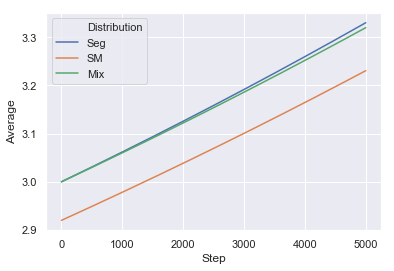

In [58]:
data_avg = []
for i in range(5000):
    for avg in all_models_avg[0]:
        data_avg.append((i, avg[i], "Seg"))
    
    for avg in all_models_avg[1]:
        data_avg.append((i, avg[i], "SM"))
    
    for avg in all_models_avg[2]:
        data_avg.append((i, avg[i], "Mix"))
        
    
da = pd.DataFrame(data_avg, columns = ["Step", "Average", "Distribution"])
ax = sns.lineplot(x= "Step", y= "Average", hue="Distribution", data=da)
L= plt.legend()
# plt.yscale('log')
plt.show()

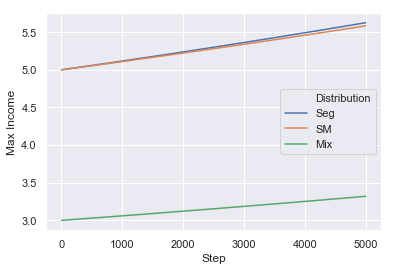

In [59]:
data_mx = []
for i in range(5000):
    for mx in all_models_mx[0]:
        data_mx.append((i, mx[i], "Seg"))
    
    for mx in all_models_mx[1]:
        data_mx.append((i, mx[i], "SM"))
    
    for mx in all_models_avg[2]:
        data_mx.append((i, mx[i], "Mix"))
    

dmx = pd.DataFrame(data_mx, columns = ["Step", "Max Income", "Distribution"])
ax = sns.lineplot(x= "Step", y= "Max Income", hue="Distribution", data=dmx, legend='brief')
L=plt.legend()
# plt.yscale('log')
plt.show()

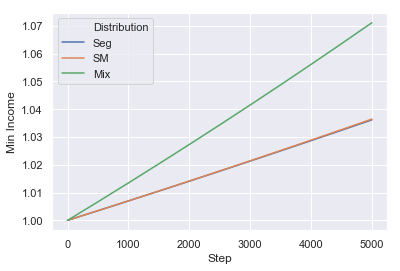

In [60]:
data_mn = []
for i in range(5000):
    for mn in all_models_mn[0]:
        data_mn.append((i, mn[i], "Seg"))
    
    for mn in all_models_mn[1]:
        data_mn.append((i, mn[i], "SM"))
    
    for mn in all_models_mn[2]:
        data_mn.append((i, mn[i], "Mix"))

dmn = pd.DataFrame(data_mn, columns = ["Step", "Min Income", "Distribution"])
ax = sns.lineplot(x= "Step", y= "Min Income", hue="Distribution", data=dmn, legend='brief')
L=plt.legend()
# plt.yscale('log')
plt.show()

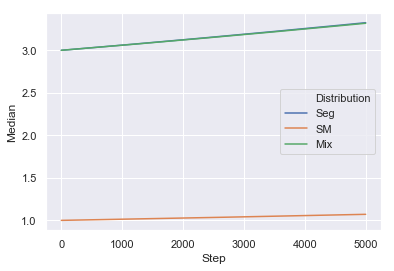

In [61]:
data_m = []
for i in range(5000):
    for m in all_models_m[0]:
        data_m.append((i, m[i], "Seg"))
    
    for m in all_models_m[1]:
        data_m.append((i, m[i], "SM"))
        
    for m in all_models_m[2]:
        data_m.append((i, m[i], "Mix"))

dm = pd.DataFrame(data_m, columns = ["Step", "Median", "Distribution"])
ax = sns.lineplot(x= "Step", y= "Median", hue="Distribution", data=dm, legend='brief')
# L=plt.legend()
# plt.yscale('log')
plt.show()

# Uncorrelated

In [69]:
all_models_avg = [] 
all_models_m = []
all_models_mx = [] 
all_models_mn = []  

for distr in ["Seg", "SM", "Mix"]:
    
    overall_avg_models = []
    overall_median_models = []
    overall_max_models = []
    overall_min_models = []
    
    for i in range(1):
        sim = Stochastic_Schelling(distr=distr)
        sims_avg_models=[]
        sims_median_models=[]
        sims_max_models=[]
        sims_min_models=[]
        
        for _ in range(5000):
            sim.update_grid()
            sims_avg_models.append(sim.get_avg_val(sim.wealth))
            sims_median_models.append(sim.get_median(sim.wealth))
            sims_max_models.append(sim.get_max_val(sim.wealth))
            sims_min_models.append(sim.get_min_val(sim.wealth))
            
        overall_avg_models.append(sims_avg_models)
        overall_median_models.append(sims_median_models)
        overall_max_models.append(sims_max_models)
        overall_min_models.append(sims_min_models)
        
    all_models_avg.append(overall_avg_models)
    all_models_m.append(overall_median_models)
    all_models_mx.append(overall_max_models)
    all_models_mn.append(overall_min_models)

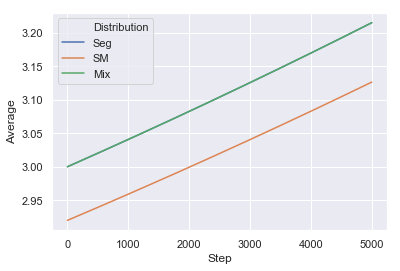

In [70]:
data_avg = []
for i in range(5000):
    for avg in all_models_avg[0]:
        data_avg.append((i, avg[i], "Seg"))
    
    for avg in all_models_avg[1]:
        data_avg.append((i, avg[i], "SM"))
    
    for avg in all_models_avg[2]:
        data_avg.append((i, avg[i], "Mix"))
        
    
da = pd.DataFrame(data_avg, columns = ["Step", "Average", "Distribution"])
ax = sns.lineplot(x= "Step", y= "Average", hue="Distribution", data=da, legend='brief')
# L=plt.legend()
# plt.yscale('log')
# plt.axis([420,500, (5*10**3), np.max(da.Average)])
plt.show()

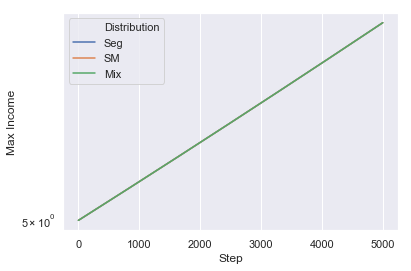

In [71]:
data_mx = []
for i in range(5000):
    for mx in all_models_mx[0]:
        data_mx.append((i, mx[i], "Seg"))
    
    for mx in all_models_mx[1]:
        data_mx.append((i, mx[i], "SM"))
    
    for mx in all_models_mx[2]:
        data_mx.append((i, mx[i], "Mix"))

dmx = pd.DataFrame(data_mx, columns = ["Step", "Max Income", "Distribution"])
ax = sns.lineplot(x= "Step", y= "Max Income", hue="Distribution", data=dmx, legend='brief')
# L=plt.legend()
plt.yscale('log')
plt.show()

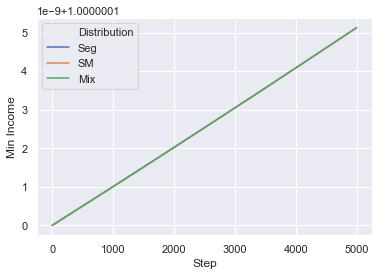

In [72]:
data_mn = []
for i in range(5000):
    for mn in all_models_mn[0]:
        data_mn.append((i, mn[i], "Seg"))
    
    for mn in all_models_mn[1]:
        data_mn.append((i, mn[i], "SM"))
        
    for mn in all_models_mn[2]:
        data_mn.append((i, mn[i], "Mix"))

dmn = pd.DataFrame(data_mn, columns = ["Step", "Min Income", "Distribution"])
ax = sns.lineplot(x= "Step", y= "Min Income", hue="Distribution", data=dmn, legend='brief')
L=plt.legend()
# plt.yscale('log')
plt.show()

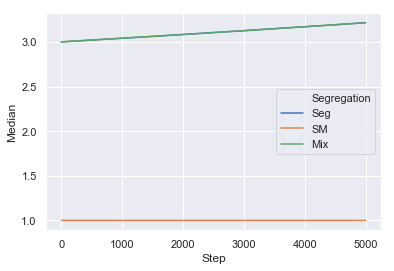

In [73]:
data_m = []
for i in range(5000):
    for m in all_models_m[0]:
        data_m.append((i, m[i], "Seg"))
    
    for m in all_models_m[1]:
        data_m.append((i, m[i], "SM"))
        
    for m in all_models_m[2]:
        data_m.append((i, m[i], "Mix"))

dm = pd.DataFrame(data_m, columns = ["Step", "Median", "Segregation"])
ax = sns.lineplot(x= "Step", y= "Median", hue="Segregation", data=dm, legend='brief')
L=plt.legend()
# plt.yscale('log')
plt.show()

# Scaling - Double Size (20, 20)

In [63]:
all_models_avg = [] 
all_models_m = []
all_models_mx = [] 
all_models_mn = []  

for distr in ["Seg", "SM", "Mix"]:
    
    overall_avg_models = []
    overall_median_models = []
    overall_max_models = []
    overall_min_models = []
    
    for i in range(1):
        sim = Stochastic_Schelling(distr=distr, grid_size = (20, 20))
        sims_avg_models=[]
        sims_median_models=[]
        sims_max_models=[]
        sims_min_models=[]
        
        for _ in range(5000):
            sim.update_grid()
            sims_avg_models.append(sim.get_avg_val(sim.wealth))
            sims_median_models.append(sim.get_median(sim.wealth))
            sims_max_models.append(sim.get_max_val(sim.wealth))
            sims_min_models.append(sim.get_min_val(sim.wealth))
            
        overall_avg_models.append(sims_avg_models)
        overall_median_models.append(sims_median_models)
        overall_max_models.append(sims_max_models)
        overall_min_models.append(sims_min_models)
        
    all_models_avg.append(overall_avg_models)
    all_models_m.append(overall_median_models)
    all_models_mx.append(overall_max_models)
    all_models_mn.append(overall_min_models)

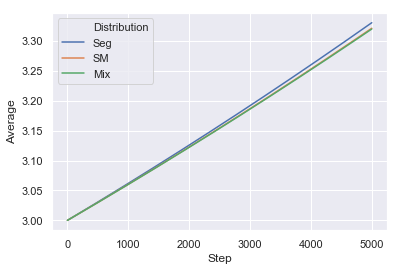

In [64]:
data_avg = []
for i in range(5000):
    for avg in all_models_avg[0]:
        data_avg.append((i, avg[i], "Seg"))
    
    for avg in all_models_avg[1]:
        data_avg.append((i, avg[i], "SM"))
        
    for avg in all_models_avg[2]:
        data_avg.append((i, avg[i], "Mix"))
        
    
da = pd.DataFrame(data_avg, columns = ["Step", "Average", "Distribution"])
ax = sns.lineplot(x= "Step", y= "Average", hue="Distribution", data=da, legend='brief')
L=plt.legend()
# plt.yscale('log')
# plt.axis([420,500, (5*10**3), np.max(da.Average)])
plt.show()

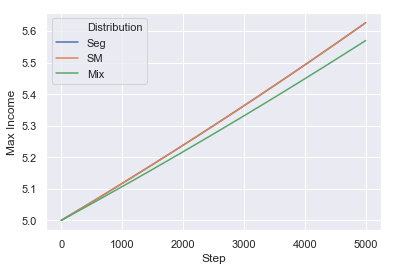

In [65]:
data_mx = []
for i in range(5000):
    for mx in all_models_mx[0]:
        data_mx.append((i, mx[i], "Seg"))
    
    for mx in all_models_mx[1]:
        data_mx.append((i, mx[i], "SM"))
        
    for mx in all_models_mx[2]:
        data_mx.append((i, mx[i], "Mix"))

dmx = pd.DataFrame(data_mx, columns = ["Step", "Max Income", "Distribution"])
ax = sns.lineplot(x= "Step", y= "Max Income", hue="Distribution", data=dmx, legend='brief')
L=plt.legend()
# plt.yscale('log')
plt.show()

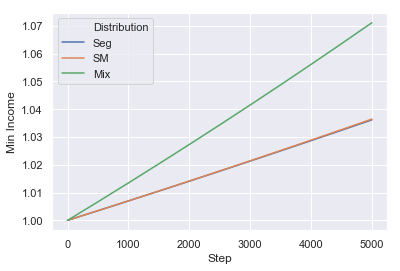

In [66]:
data_mn = []
for i in range(5000):
    for mn in all_models_mn[0]:
        data_mn.append((i, mn[i], "Seg"))
    
    for mn in all_models_mn[1]:
        data_mn.append((i, mn[i], "SM"))
        
    for mn in all_models_mn[2]:
        data_mn.append((i, mn[i], "Mix"))

dmn = pd.DataFrame(data_mn, columns = ["Step", "Min Income", "Distribution"])
ax = sns.lineplot(x= "Step", y= "Min Income", hue="Distribution", data=dmn, legend='brief')
L=plt.legend()
# plt.yscale('log')
plt.show()

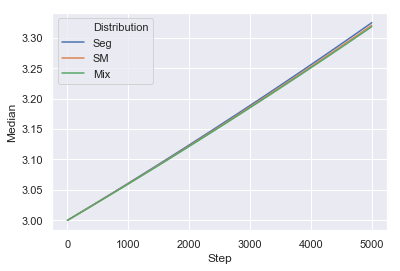

In [67]:
data_m = []
for i in range(5000):
    for m in all_models_m[0]:
        data_m.append((i, m[i], "Seg"))
    
    for m in all_models_m[1]:
        data_m.append((i, m[i], "SM"))
        
    for m in all_models_m[2]:
        data_m.append((i, m[i], "Mix"))

dm = pd.DataFrame(data_m, columns = ["Step", "Median", "Distribution"])
ax = sns.lineplot(x= "Step", y= "Median", hue="Distribution", data=dm, legend='brief')
L=plt.legend()
# plt.yscale('log')
plt.show()

# Check Effect of Neighborhood Size

In [44]:
all_models_avg = [] 
all_models_m = []
all_models_mx = [] 
all_models_mn = []  

for n in [2, 4, 8]:
    
    overall_avg_models = []
    overall_median_models = []
    overall_max_models = []
    overall_min_models = []
    
    for i in range(1):
        sim = Stochastic_Schelling(n= n)
        sims_avg_models=[]
        sims_median_models=[]
        sims_max_models=[]
        sims_min_models=[]
        
        for _ in range(5000):
            sim.update_grid()
            sims_avg_models.append(sim.get_avg_val(sim.wealth))
            sims_median_models.append(sim.get_median(sim.wealth))
            sims_max_models.append(sim.get_max_val(sim.wealth))
            sims_min_models.append(sim.get_min_val(sim.wealth))
            
        overall_avg_models.append(sims_avg_models)
        overall_median_models.append(sims_median_models)
        overall_max_models.append(sims_max_models)
        overall_min_models.append(sims_min_models)
        
    all_models_avg.append(overall_avg_models)
    all_models_m.append(overall_median_models)
    all_models_mx.append(overall_max_models)
    all_models_mn.append(overall_min_models)

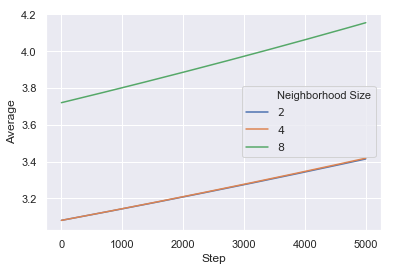

In [45]:
data_avg = []
for i in range(5000):
    for avg in all_models_avg[0]:
        data_avg.append((i, avg[i], 2))
    
    for avg in all_models_avg[1]:
        data_avg.append((i, avg[i], 4))
        
    for avg in all_models_avg[2]:
        data_avg.append((i, avg[i], 8))
        
    
da = pd.DataFrame(data_avg, columns = ["Step", "Average", "Neighborhood Size"])
da["Neighborhood Size"] = ["$%s$" % x for x in da["Neighborhood Size"]]

ax = sns.lineplot(x= "Step", y= "Average", hue="Neighborhood Size", data=da, legend='brief')
L=plt.legend()
plt.show()

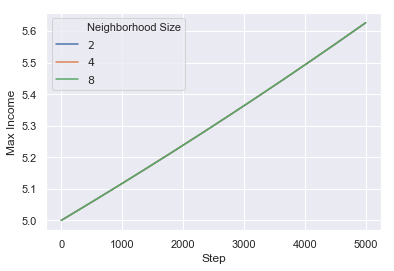

In [46]:
data_mx = []
for i in range(5000):
    for mx in all_models_mx[0]:
        data_mx.append((i, mx[i], 2))
    
    for mx in all_models_mx[1]:
        data_mx.append((i, mx[i], 4))
        
    for mx in all_models_mx[2]:
        data_mx.append((i, mx[i], 8))

dmx = pd.DataFrame(data_mx, columns = ["Step", "Max Income", "Neighborhood Size"])

dmx["Neighborhood Size"] = ["$%s$" % x for x in dmx["Neighborhood Size"]]

ax = sns.lineplot(x= "Step", y= "Max Income", hue="Neighborhood Size", data=dmx, legend='brief')
L=plt.legend()
plt.show()

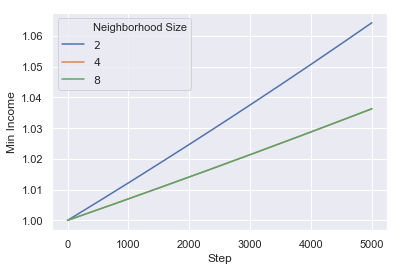

In [47]:
data_mn = []
for i in range(5000):
    for mn in all_models_mn[0]:
        data_mn.append((i, mn[i], 2))
    
    for mn in all_models_mn[1]:
        data_mn.append((i, mn[i], 4))
        
    for mn in all_models_mn[2]:
        data_mn.append((i, mn[i], 8))

dmn = pd.DataFrame(data_mn, columns = ["Step", "Min Income", "Neighborhood Size"])

dmn["Neighborhood Size"] = ["$%s$" % x for x in dmn["Neighborhood Size"]]

ax = sns.lineplot(x= "Step", y= "Min Income", hue="Neighborhood Size", data=dmn, legend='brief')
L=plt.legend()
plt.show()

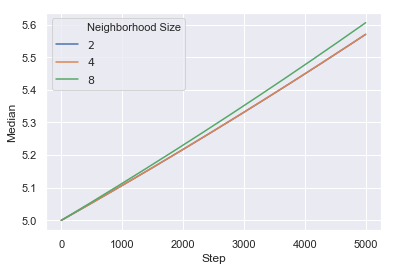

In [48]:
data_m = []
for i in range(5000):
    for m in all_models_m[0]:
        data_m.append((i, m[i], 2))
    
    for m in all_models_m[1]:
        data_m.append((i, m[i], 4))
        
    for m in all_models_m[2]:
        data_m.append((i, m[i], 8))

dm = pd.DataFrame(data_m, columns = ["Step", "Median", "Neighborhood Size"])

dm["Neighborhood Size"] = ["$%s$" % x for x in dm["Neighborhood Size"]]

ax = sns.lineplot(x= "Step", y= "Median", hue="Neighborhood Size", data=dm, legend='brief')
L=plt.legend()
plt.show()